In [22]:
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import PCA
from Jvis import JUMAP, UMAP
import sys
from timeit import default_timer as timer
import time
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [4]:
def shuffle_rows(expression_matrix, prop, random_seed):
    np.random.seed(random_seed)
    n_rows, n_cols = expression_matrix.shape
    n_elem = round(prop*n_cols)
    s = np.arange(n_cols)
    row_id = list(np.random.choice(s, size=n_elem, replace=False))
    v = expression_matrix[:, row_id]
    np.random.shuffle(np.transpose(v))
    expression_matrix[:, row_id] = v
    
def normalize_matrix(A, option = "Frobenius"):
    if option == "Frobenius":
        return (A/np.linalg.norm(A))
    elif option == "max":
        return (A/A.max())
    else:
        "Not implemented yet"

In [23]:
data_set_all = ['GeqN1k', 'GeqN1kD1k', 'GeqN5k', 'GeqN5kD1k', 'GpbmcN1k', 'GpbmcN1kD1k', 'GpbmcN5k', 'GpbmcN5kD1k']

In [39]:
data_set = data_set_all[3]

In [40]:
# Read the expr matrix
expr_mat = genfromtxt('../sim_splat/data/'+data_set+'_rna.csv',  delimiter=',')
labels_true = genfromtxt('../sim_splat/data/'+data_set+'_labels.csv', delimiter=',')
# labels_true = labels_true.values.flatten()
expr_mat_log_t = expr_mat
print("RNA_shape", expr_mat.shape)
expr_reduced = PCA(n_components=50).fit_transform(expr_mat_log_t)

# Read ADT
adt_mat = genfromtxt('../sim_splat/data/'+data_set+'_adt.csv', delimiter=',')
print("ADT shape: ", adt_mat.shape)

start = time.time()
noise_level = 0.2
# for noise_level in [0.2]:
# Create noise
print("Dataset: ", data_set)
print("Noise level: ", noise_level)
expr_mat_shuffle = np.copy(expr_mat)
shuffle_rows(expr_mat_shuffle.T, prop = noise_level, random_seed=0)

if expr_mat_shuffle.shape[1] <500:
    expr_reduced_shufle = expr_mat_shuffle
else:
    expr_reduced_shufle = PCA(n_components=50).fit_transform(expr_mat_shuffle)

maxIter = 25 if adt_mat.shape[0] < 4000 else 15

joint_umap_obj = JUMAP(init='random')
data = {'modal-1': expr_reduced, 'modal-2': adt_mat,  'modal-noise': expr_reduced_shufle}
# joint_umap = joint_umap_obj.fit_transform(X = data, method = 'auto', ld = 0.5, max_iter=maxIter)
joint_umap = joint_umap_obj.fit(data, alpha=[0.45, 0.45, 0.1])

RNA_shape (5000, 1000)
ADT shape:  (5000, 49)
Dataset:  GeqN5kD1k
Noise level:  0.2


In [41]:
JointEL_embedding = joint_umap_obj.embedding_

In [42]:
concat = np.concatenate((expr_reduced, adt_mat, expr_mat_shuffle), axis = 1)
scaler = preprocessing.StandardScaler().fit(concat)
X_scaled = scaler.transform(concat)
umap_ZScale = UMAP().fit_transform(X_scaled)

In [43]:
concatRangeScale = np.concatenate((normalize_matrix(expr_reduced, "max"), normalize_matrix(adt_mat, "max"), normalize_matrix(expr_mat_shuffle, "max")), axis = 1)
umap_RangeScale= UMAP().fit_transform(concatRangeScale)

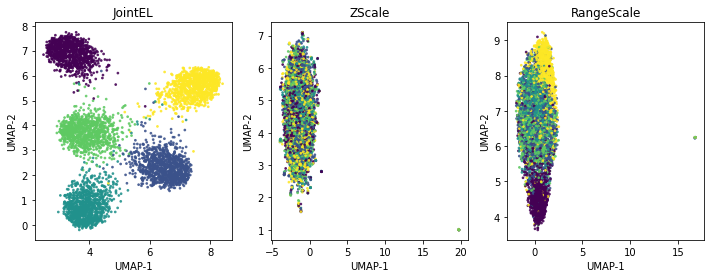

In [44]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
ax.scatter(JointEL_embedding[:,0], JointEL_embedding[:,1], s=3, c = labels_true, alpha=0.8)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_title('JointEL')
ax = fig.add_subplot(132)
ax.scatter(umap_ZScale[:,0], umap_ZScale[:,1], s=3, c = labels_true, alpha=0.8)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_title('ZScale')
ax = fig.add_subplot(133)
ax.scatter(umap_RangeScale[:,0], umap_RangeScale[:,1], s=3, c = labels_true, alpha=0.8)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_title('RangeScale')
plt.savefig('../visualization/'+data_set+'_UMAP.pdf', bbox_inches='tight')
plt.show()